# Parametric working memory 
Code for exercise 3

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch_directml
from torch.utils.data import DataLoader
from sklearn.mixture import GaussianMixture 
import dataset.generate_dataset as generate_dataset
import models.neural_networks as neural_networks 
import models.latent_dynamics as latent_dynamics
import evaluation.visualise_dynamics as visualise_dynamics
import evaluation.visualise_connectivity as visualise_connectivity
import matplotlib.colors as mcolors
import scipy 

device = torch_directml.device()
print('Using {}'.format(device))

np.random.seed(0)
torch.manual_seed(1)
list_colors = list(mcolors.TABLEAU_COLORS)

Using privateuseone:0


## 1. Generate data.

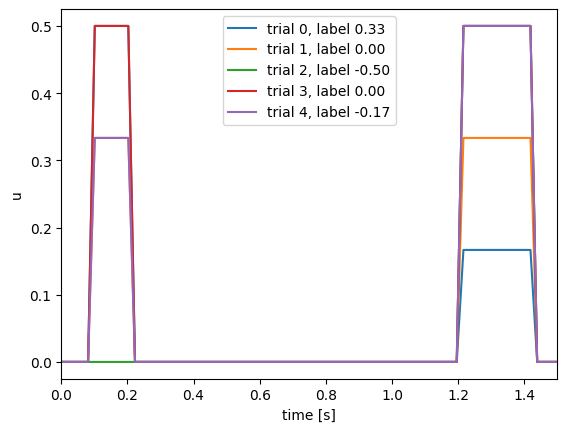

In [30]:
batch_size = 32
num_batches = 100
num_trials = batch_size * num_batches
sampling_rate = 1/(20/1000) #[Hz]
first_onset = 5 # time step 
first_period = 5 # time step 
first_offset = first_onset+first_period  # time step 
delay = 50 # time step 
second_onset = first_offset + delay # time step 
second_period = 10 # time step
second_offset = second_onset + second_period 
decision_period = 5

t_onsets = np.array([first_onset, second_onset]) / sampling_rate # [s]
t_offsets = np.array([first_offset, second_offset]) / sampling_rate # [s]
t_max = (second_offset + decision_period) / sampling_rate# [s]
num_trial_to_plot = 5 # should be less than batch_size
stimulus_strength_list  = np.arange(10, 38, 4)

PWM_dataset_train = \
    generate_dataset.PWMStimulus(num_trials, t_onsets, t_offsets, t_max, stimulus_strength_list, sampling_rate)
PWM_dataset_test = \
    generate_dataset.PWMStimulus(int(num_trials/100), t_onsets, t_offsets, t_max, stimulus_strength_list, sampling_rate)

fig = PWM_dataset_train.plot_stimulus(np.arange(num_trial_to_plot))
plt.show()

In [3]:
train_dataloader = \
    DataLoader(PWM_dataset_train, batch_size=batch_size)#, shuffle=True)
test_dataloader = \
    DataLoader(PWM_dataset_test, batch_size=batch_size)#, shuffle=True)

## 2. Low rank RNN  

In [4]:
input_size = 1
hidden_size = 128 
output_size = 1
rank = 2
time_step = 20/1000 # s 
tau = 100/1000 # s
model = neural_networks.LowRankRNN(
    input_size, hidden_size, 
    output_size, rank, 
    time_step, tau).to(device)
print(model)

LowRankRNN(
  (feedforward_input): LinearAmpFactor(in_features=1, out_features=128)
  (recurrent_input): RNNLayer(in_features=128, out_features=128)
  (readout): LinearAmpFactor(in_features=128, out_features=1)
)


Run simulation & Visualise a time course of each hidden node.  

try simulation for the first batch
shape of stimulus:  torch.Size([32, 75])
shape of label: torch.Size([32])


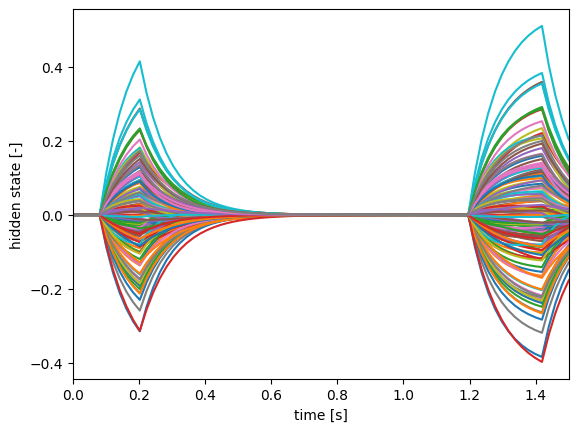

In [5]:
sample_batched = next(iter(train_dataloader))
print('try simulation for the first batch')
print('shape of stimulus: ', sample_batched['stimulus'].size())
print('shape of label:', sample_batched['label'].size())

visualise_dynamics.plot_hidden_nodes_single_trial(
    device, model, t_max, PWM_dataset_train, train_dataloader)

## 3. Train network

In [6]:
loss_fn = torch.nn.MSELoss(reduction='mean')
learning_rate = 5e-2
loss_min = 5e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
time_step_for_loss = decision_period # time step     
num_epochs = 10

In [7]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, time_step_for_loss):
    num_batches = len(dataloader)
    loss_history = []
    for i_batch, sample_batched in enumerate(dataloader):
        #print(i_batch, sample_batched['stimulus'].size(),
        #      sample_batched['label'].size())      
              
        _batch_size = len(sample_batched['stimulus'])
        hidden_state = model.init_hidden(_batch_size)        
        loss = 0 
        optimizer.zero_grad()
        #print(sample_batched['stimulus'].shape)
        num_sample_points = sample_batched['stimulus'].shape[1]
        
        for i_time in range(num_sample_points):
            #print(sample_batched['stimulus'].shape)
            input_data = sample_batched['stimulus'][:, i_time].unsqueeze(dim=1).to(device)
            label_data = sample_batched['label'].float().to(device)
            hidden_state = hidden_state.to(device)
            output, hidden_state = model(input_data, hidden_state)
            
            if i_time >=(num_sample_points - time_step_for_loss):
                #print(output.shape)
                #print(loss_fn(output.squeeze().to(device), label_data))
                loss += loss_fn(output.squeeze().to(device), label_data)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        loss = loss.item() 
        
        if i_batch % 25 == 0 or i_batch == num_batches-1:
            print(f"loss: {loss:>7f}, batch [{(i_batch+1):>5d}/{num_batches:>5d}]")
        
        loss_history.append(loss)

    return loss_history 

def test(dataloader, model, loss_fn, time_step_for_loss):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0 
    correct = 0
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(dataloader):
            _batch_size = len(sample_batched['stimulus'])
            hidden_state = model.init_hidden(_batch_size)
            num_sample_points = sample_batched['stimulus'].shape[1]
         
            for i_time in range(num_sample_points):
                input_data = sample_batched['stimulus'][:, i_time].unsqueeze(dim=1).to(device)
                label_data = sample_batched['label'].float().to(device)
                hidden_state = hidden_state.to(device)
                output, hidden_state = model(input_data, hidden_state)   
             
            if i_time >=(num_sample_points - time_step_for_loss):
                test_loss += loss_fn(output.squeeze().to(device), label_data)

            correct += ((output.sign() * label_data) == 1).sum().item() / _batch_size

    test_loss /= num_batches
    correct /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epoch : 0


/home/yota/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/optim/adam.py:522: UserWarning: The operator 'aten::_foreach_lerp_.Scalar' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)


loss: 1.162895, batch [    1/   50]
loss: 0.620263, batch [   26/   50]
loss: 0.478585, batch [   50/   50]
epoch : 1
loss: 0.616645, batch [    1/   50]
loss: 0.608659, batch [   26/   50]
loss: 0.477154, batch [   50/   50]
epoch : 2
loss: 0.614566, batch [    1/   50]
loss: 0.598305, batch [   26/   50]
loss: 0.477560, batch [   50/   50]
epoch : 3
loss: 0.614803, batch [    1/   50]
loss: 0.593757, batch [   26/   50]
loss: 0.477790, batch [   50/   50]
epoch : 4
loss: 0.614636, batch [    1/   50]
loss: 0.592108, batch [   26/   50]
loss: 0.477473, batch [   50/   50]
epoch : 5
loss: 0.613911, batch [    1/   50]
loss: 0.592005, batch [   26/   50]
loss: 0.476874, batch [   50/   50]
epoch : 6
loss: 0.612970, batch [    1/   50]
loss: 0.592345, batch [   26/   50]
loss: 0.476210, batch [   50/   50]
epoch : 7
loss: 0.612012, batch [    1/   50]
loss: 0.592749, batch [   26/   50]
loss: 0.475558, batch [   50/   50]
epoch : 8
loss: 0.611094, batch [    1/   50]
loss: 0.593124, batc

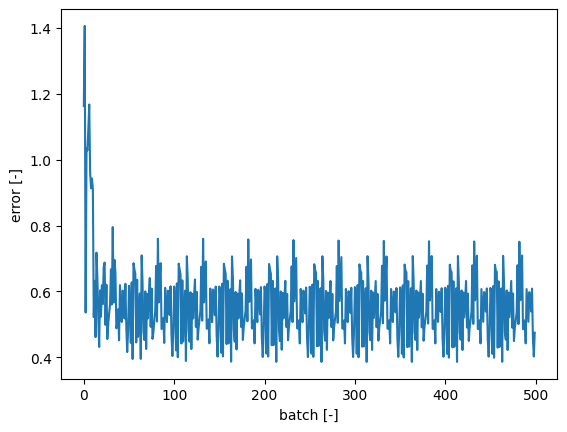

In [8]:
# train model 
loss_history = []

for i_epoch in range(num_epochs):
    print(f'epoch : {i_epoch}')
    loss_history_one_epoch = \
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, time_step_for_loss)
    loss_history.extend(loss_history_one_epoch)        
    
    if loss_history[-1] < loss_min:
        break
#assert (loss_history[-1] < loss_min)

plt.plot(loss_history)
plt.xlabel('batch [-]')
plt.ylabel('error [-]')
plt.show()

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.112420 



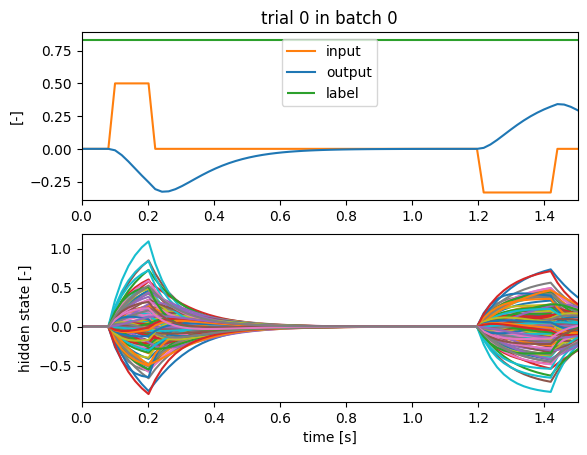

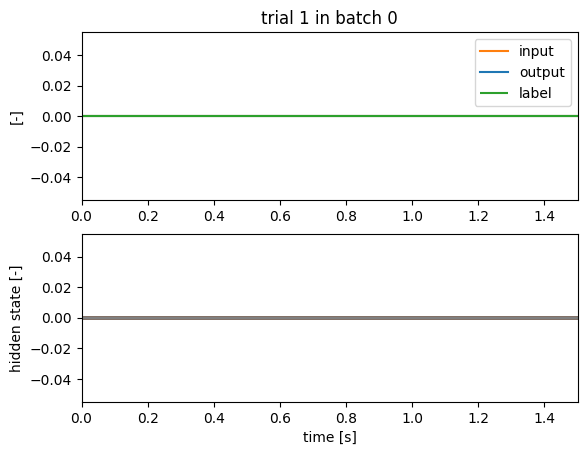

In [9]:
# test model 
test(test_dataloader, model, loss_fn, time_step_for_loss)

# visualise dynamics of trained RNN
visualise_dynamics.plot_dynamics_each_trial(
    device, model, t_max, PWM_dataset_test, 
    test_dataloader, num_trial_to_plot=2)

### Curriculum learning by increasing the inter-stimulus interval. 
Increase the difficulty of the task in a training dataset to obtain better models.

Check a training dataset. 

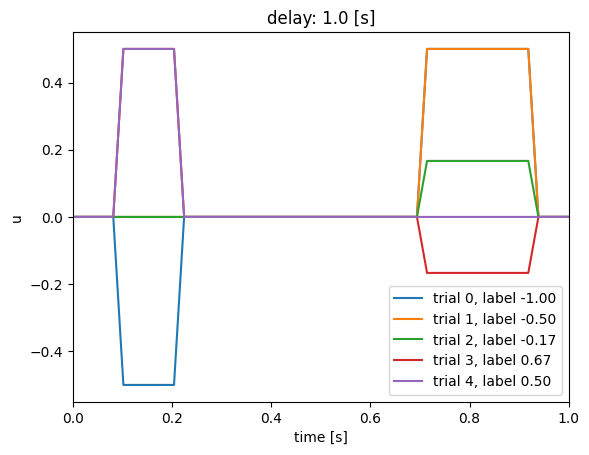

In [10]:
# gradually increase delays between two stimuli [s]
delays = np.array([25, 35, 45, 50])

# check the 1st delay
second_onset = first_offset + delays[0] # time step 
second_offset = second_onset + second_period 
t_onsets_curriculum_learning = np.array([first_onset, second_onset]) / sampling_rate # [s]
t_offsets_curriculum_learning = np.array([first_offset, second_offset]) / sampling_rate # [s]
t_max_curriculum_learning = (second_offset + decision_period) /sampling_rate  # [s]

PWM_dataset_train_curriculum_learning = \
    generate_dataset.PWMStimulus(num_trials, 
                                 t_onsets_curriculum_learning, 
                                 t_offsets_curriculum_learning, 
                                 t_max_curriculum_learning, 
                                 stimulus_strength_list, 
                                 sampling_rate)

stimuli, labels = PWM_dataset_train_curriculum_learning.generate_data()

for i_trial in range(num_trial_to_plot):
    plt.plot(PWM_dataset_train_curriculum_learning.time, stimuli[i_trial, :], \
                label='trial {:d}, label {:.2f}'.format(int(i_trial), labels[i_trial]))
plt.xlim(0, max(PWM_dataset_train_curriculum_learning.time))
plt.vlines(t_onsets[-1], -np.inf, np.inf)
plt.xlabel('time [s]')
plt.ylabel('u')
plt.legend()
plt.title(f'delay: {delay/sampling_rate} [s]')
plt.show()

A new model.


In [26]:
model_curriculum_learning = neural_networks.LowRankRNN(
    input_size, hidden_size, 
    output_size, rank, 
    time_step, tau).to(device)
print(model_curriculum_learning)

loss_fn_curriculum_learning = \
    torch.nn.MSELoss(reduction='mean')

optimizer_curriculum_learning = \
    torch.optim.Adam(model_curriculum_learning.parameters(), lr=learning_rate)

LowRankRNN(
  (feedforward_input): LinearAmpFactor(in_features=1, out_features=128)
  (recurrent_input): RNNLayer(in_features=128, out_features=128)
  (readout): LinearAmpFactor(in_features=128, out_features=1)
)


Train the model.

---- epoch : 0 -----
delay = 0.5 [s]
loss: 0.548130, batch [    1/   25]
loss: 0.570570, batch [   25/   25]
delay = 0.7 [s]
loss: 0.553752, batch [    1/   25]
loss: 0.572987, batch [   25/   25]
delay = 0.9 [s]
loss: 0.504793, batch [    1/   25]
loss: 0.475123, batch [   25/   25]
delay = 1.0 [s]
loss: 0.870116, batch [    1/   25]
loss: 0.483755, batch [   25/   25]
---- epoch : 1 -----
delay = 0.5 [s]
loss: 0.655766, batch [    1/   25]
loss: 0.529126, batch [   25/   25]
delay = 0.7 [s]
loss: 0.621434, batch [    1/   25]
loss: 0.650105, batch [   25/   25]
delay = 0.9 [s]
loss: 0.505004, batch [    1/   25]
loss: 0.592106, batch [   25/   25]
delay = 1.0 [s]
loss: 0.573783, batch [    1/   25]
loss: 0.496315, batch [   25/   25]
---- epoch : 2 -----
delay = 0.5 [s]
loss: 0.550659, batch [    1/   25]
loss: 0.493263, batch [   25/   25]
delay = 0.7 [s]
loss: 0.472936, batch [    1/   25]
loss: 0.607510, batch [   25/   25]
delay = 0.9 [s]
loss: 0.557719, batch [    1/   25]
loss:

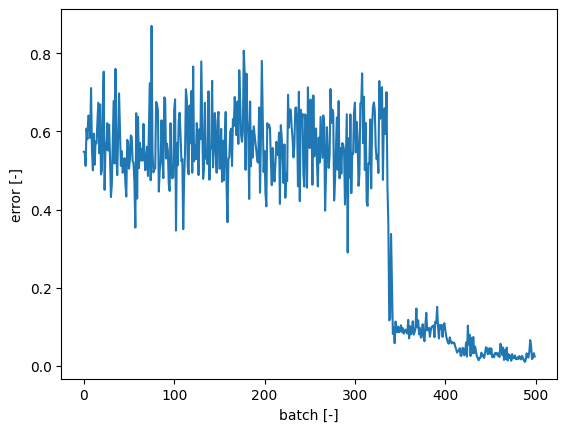

In [31]:
num_epochs_curriculum_learning = int(np.floor(num_epochs / len(delays)))
loss_history_curriculum_learning = []
num_trials_curriculum_learning = \
    batch_size * int(np.floor(num_batches/len(delays)))

for i_epoch in range(num_epochs):
    print(f'---- epoch : {i_epoch} -----')
          
    for delay_now in delays:
        print(f'delay = {delay_now/sampling_rate} [s]')

        second_onset = first_offset + delay_now # time step 
        second_offset = second_onset + second_period 
        t_onsets_curriculum_learning = np.array([first_onset, second_onset]) / sampling_rate # [s]
        t_offsets_curriculum_learning = np.array([first_offset, second_offset]) / sampling_rate # [s]
        t_max_curriculum_learning = (second_offset + decision_period) /sampling_rate  # [s]
        
        PWM_dataset_train_curriculum_learning = \
            generate_dataset.PWMStimulus(num_trials_curriculum_learning,
                                        t_onsets_curriculum_learning,
                                        t_offsets_curriculum_learning,
                                        t_max_curriculum_learning,
                                        stimulus_strength_list,
                                        sampling_rate)

        train_dataloader_curriculum_learning = \
            DataLoader(PWM_dataset_train_curriculum_learning, 
                    batch_size=batch_size, shuffle=True)

        loss_history_curriculum_learning_one_epoch = \
            train_one_epoch(train_dataloader_curriculum_learning, 
                            model_curriculum_learning, 
                            loss_fn_curriculum_learning, 
                            optimizer_curriculum_learning, 
                            time_step_for_loss)
        
        loss_history_curriculum_learning.extend(loss_history_curriculum_learning_one_epoch)

    if loss_history_curriculum_learning[-1] < loss_min:
        break

assert (loss_history_curriculum_learning[-1] < loss_min)

plt.plot(loss_history_curriculum_learning)
plt.xlabel('batch [-]')
plt.ylabel('error [-]')
plt.show()

In [13]:
"""
num_epochs_curriculum_learning = int(np.floor(num_epochs / len(delays)))
loss_history_curriculum_learning = []


for i_epoch in range(num_epochs_curriculum_learning):
    print(f'---- epoch : {i_epoch} -----')
          
    for delay_now in delays:
        print(f'delay = {delay_now/sampling_rate} [s]')

        second_onset = first_offset + delay_now # time step 
        second_offset = second_onset + second_period 
        t_onsets_curriculum_learning = np.array([first_onset, second_onset]) / sampling_rate # [s]
        t_offsets_curriculum_learning = np.array([first_offset, second_offset]) / sampling_rate # [s]
        t_max_curriculum_learning = (second_offset + decision_period) /sampling_rate  # [s]
        
        PWM_dataset_train_curriculum_learning = \
            generate_dataset.PWMStimulus(num_trials,
                                        t_onsets_curriculum_learning,
                                        t_offsets_curriculum_learning,
                                        t_max_curriculum_learning,
                                        stimulus_strength_list,
                                        sampling_rate)

        train_dataloader_curriculum_learning = \
            DataLoader(PWM_dataset_train_curriculum_learning, 
                    batch_size=batch_size, shuffle=True)

        loss_history_curriculum_learning_one_epoch = \
            train_one_epoch(train_dataloader_curriculum_learning, 
                            model_curriculum_learning, 
                            loss_fn_curriculum_learning, 
                            optimizer_curriculum_learning, 
                            time_step_for_loss)
        
        loss_history_curriculum_learning.extend(loss_history_curriculum_learning_one_epoch)

    if loss_history_curriculum_learning[-1] < loss_min:
        break

assert (loss_history_curriculum_learning[-1] < loss_min)

plt.plot(loss_history_curriculum_learning)
plt.xlabel('batch [-]')
plt.ylabel('error [-]')
plt.show()
"""

"\nnum_epochs_curriculum_learning = int(np.floor(num_epochs / len(delays)))\nloss_history_curriculum_learning = []\n\n\nfor i_epoch in range(num_epochs_curriculum_learning):\n    print(f'---- epoch : {i_epoch} -----')\n          \n    for delay_now in delays:\n        print(f'delay = {delay_now/sampling_rate} [s]')\n\n        second_onset = first_offset + delay_now # time step \n        second_offset = second_onset + second_period \n        t_onsets_curriculum_learning = np.array([first_onset, second_onset]) / sampling_rate # [s]\n        t_offsets_curriculum_learning = np.array([first_offset, second_offset]) / sampling_rate # [s]\n        t_max_curriculum_learning = (second_offset + decision_period) /sampling_rate  # [s]\n        \n        PWM_dataset_train_curriculum_learning =             generate_dataset.PWMStimulus(num_trials,\n                                        t_onsets_curriculum_learning,\n                                        t_offsets_curriculum_learning,\n            

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.003112 



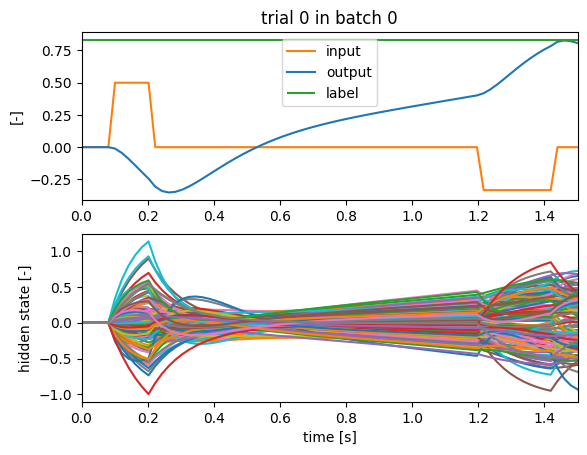

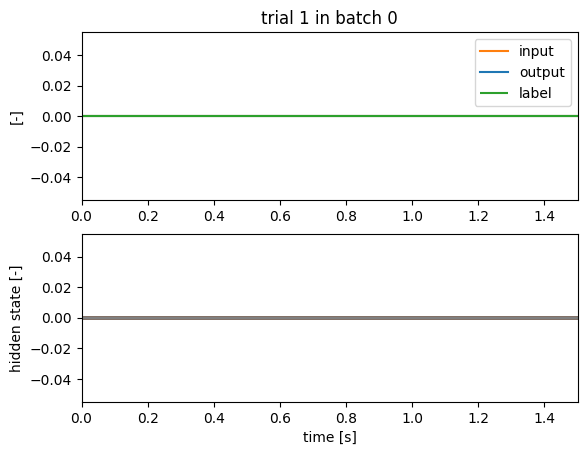

In [14]:
# test model 
test(test_dataloader, model_curriculum_learning, loss_fn, time_step_for_loss)

# visualise dynamics of trained RNN
visualise_dynamics.plot_dynamics_each_trial(
    device, model_curriculum_learning, t_max, 
    PWM_dataset_test, test_dataloader, num_trial_to_plot=2)

## 4. Analysis of selectivity and connectivity.

Compute covariance matrix in connectivity space. 

In [15]:
input_vector = model.feedforward_input.weight.cpu().detach().numpy()
readout_vector = model.readout.weight.cpu().detach().numpy().T
input_selection_vector = model.recurrent_input.right_singular_vector.cpu().detach().numpy().T
output_vector = model.recurrent_input.left_singular_vector.cpu().detach().numpy()

# set connectivity data and compute cov matrix
connectivity_data = np.hstack((input_selection_vector, output_vector, input_vector, readout_vector))
connectivity_covariance_matrix = np.cov(connectivity_data.T)
vector_names = [rf'n$^{i}$' for i in range(1, model.rank+ 1)]
vector_names.extend([rf'm$^{i}$' for i in range(1, model.rank+ 1)])
vector_names.extend(['I', 'W'])

Plot neurons in connectivity space.

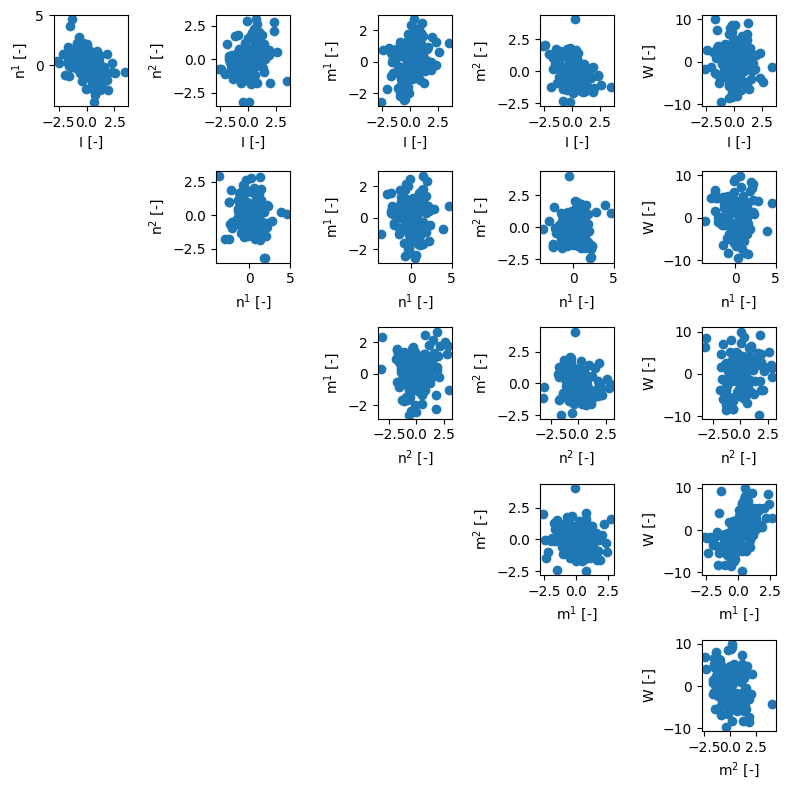

In [16]:
visualise_connectivity.plot_neurons_connectivity_space(
    connectivity_data, connectivity_covariance_matrix, model.rank)

Visualise covariance matrix.

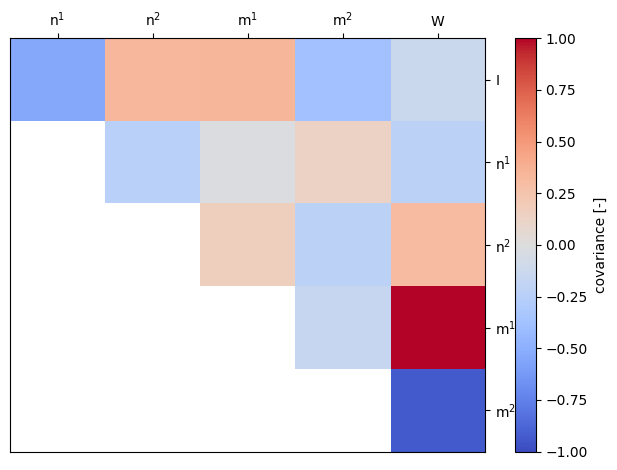

In [17]:
clim = [-1, 1]
visualise_connectivity.plot_connectivity_covariance_matrix(
    connectivity_data, connectivity_covariance_matrix, model.rank, clim)

## 5. Gaussian mixture model 

Approximate neurons in the network by a single-population GMM.

In [18]:
# fit to 4-d gaussian distribution with one population
GMM = GaussianMixture(n_components = 1, random_state=0)
GMM.fit(connectivity_data)

for i in range(connectivity_data.shape[1]):
    print(vector_names[i] + rf' mean: {GMM.means_[0][i]}')
    #GMM.covariances_

# resample from the fitted distribution
resampled_connectivity_data = \
    np.random.multivariate_normal(GMM.means_[0], GMM.covariances_[0], size=hidden_size)
print(f'shape of resampled_connectivity_data: {resampled_connectivity_data.shape}')

n$^1$ mean: 0.10373622587576392
n$^2$ mean: 0.06660631168051623
m$^1$ mean: 0.1419160191435367
m$^2$ mean: -0.03802799678669544
I mean: 0.05244113608432599
W mean: 0.28874840218850295
shape of resampled_connectivity_data: (128, 6)


Visualise original neurons and re-sampled neurons.

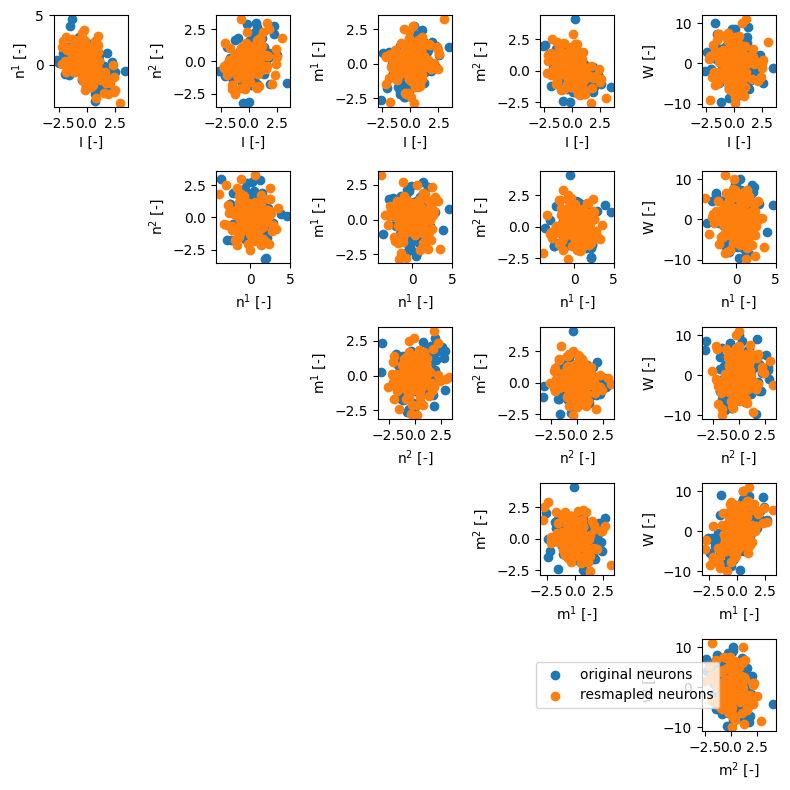

In [19]:
visualise_connectivity.plot_resampled_neurons_connectivity_space(
    resampled_connectivity_data, connectivity_data, connectivity_covariance_matrix, model.rank)

Test the network with the resampled connectivity.

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.109045 



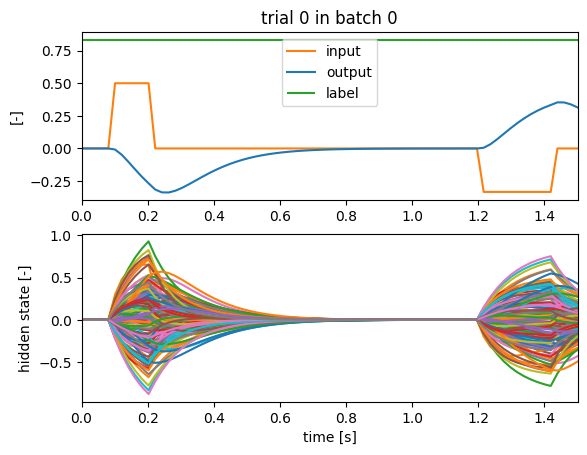

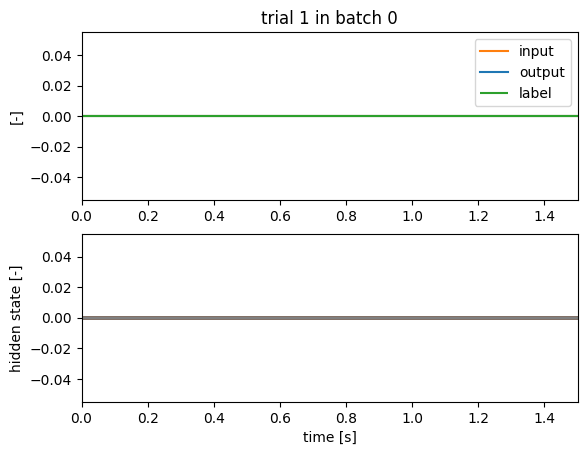

In [20]:
# Set up a network with the resampled connecitivity data.
resampled_model = \
    neural_networks.LowRankRNN(input_size, hidden_size, output_size, rank, time_step, tau).to(device)

# use resampled data for the model 
# input vector (hiddeni_size x input_size)
resampled_model.feedforward_input.weight = \
    torch.Tensor(resampled_connectivity_data[:, -2, np.newaxis])
# readout vector (output_size x hidden_size)
resampled_model.readout.weight = \
    torch.Tensor(resampled_connectivity_data[:, -1, np.newaxis].T)
# input selection vectors (rank x hidden_size)
resampled_model.recurrent_input.right_singular_vector = \
    torch.nn.Parameter(torch.Tensor(resampled_connectivity_data[:, 0:rank].T))
# output vectors (hidden_size x rank)
resampled_model.recurrent_input.left_singular_vector = \
    torch.nn.Parameter(torch.Tensor(resampled_connectivity_data[:, rank:-2]))

# test the resampled model
test(test_dataloader, resampled_model, loss_fn, time_step_for_loss)
visualise_dynamics.plot_dynamics_each_trial(
    device, resampled_model, t_max, PWM_dataset_test, test_dataloader, num_trial_to_plot=2)

## 6. Project data onto the m-I subspace.

In [21]:
sample_batched = next(iter(test_dataloader))

# run feedforward simulation and obtain the history of hidden state
hidden_state_history = np.empty((PWM_dataset_test.num_sample_points, sample_batched['stimulus'].shape[0], hidden_size))
for i_time in range(PWM_dataset_test.num_sample_points):
      input_data = sample_batched['stimulus'][:, i_time].unsqueeze(dim=1)
      if i_time == 0:
            hidden_state = model.init_hidden(input_data.shape[0])
      with torch.no_grad():
            output, hidden_state = model(input_data.to(device), hidden_state.to(device))
      hidden_state_history[i_time, :, :] = hidden_state.cpu().detach().numpy()

# project data to m 
projection_ms = (hidden_state_history @ output_vector).squeeze()
# project data to I
projection_I = (hidden_state_history @ input_vector).squeeze()

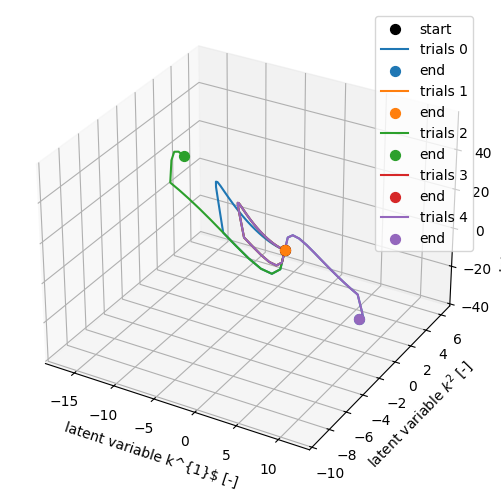

In [22]:
# plot trajectory of hidden state in the m-I plane
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(projection_ms[0, 0, 0], 
           projection_ms[0, 0, 1], 
           projection_I[0, 0], 
           s=50, color='k', label='start', zorder=10)

for i_trial in range(num_trial_to_plot):
    ax.plot(projection_ms[:, i_trial, 0],
            projection_ms[:, i_trial, 1], 
             projection_I[:, i_trial], 
             color=list_colors[i_trial],
             label=f'trials {i_trial}')
    
    ax.scatter(projection_ms[-1, i_trial, 0],
               projection_ms[-1, i_trial, 1],
               projection_I[-1, i_trial], 
               s=50, c=list_colors[i_trial], label='end', zorder=10)

ax.set_xlabel(r'latent variable k^{1}$ [-]')
ax.set_ylabel(r'latent variable $k^{2}$ [-]')
ax.set_zlabel('latent variable u [-]')
ax.legend()
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

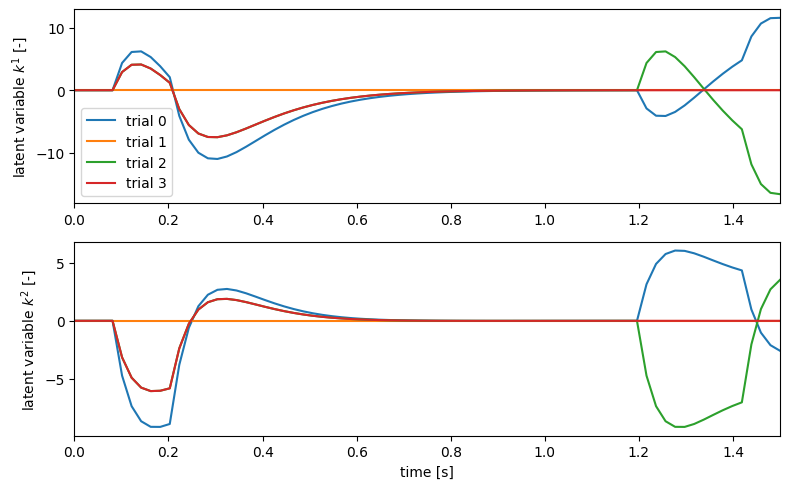

In [34]:
# plot trajectory of hidden state in the m-I plane
fig, axes = plt.subplots(rank, 1, figsize=(8, 5))

num_trial_to_plot = 4
for i_rank in range(rank):
    for i_trial in range(num_trial_to_plot):
        axes[i_rank].plot(
            PWM_dataset_test.time,
            projection_ms[:, i_trial, i_rank], 
            label=f'trial {i_trial}')
 
    axes[i_rank].set_ylabel(rf'latent variable $k^{i_rank+1}$ [-]')
    axes[i_rank].set_xlim([PWM_dataset_test.time[0], PWM_dataset_test.time[-1]])
    if i_rank == rank-1:
        axes[i_rank].set_xlabel('time [s]')
    elif i_rank == 0:
        axes[i_rank].legend()

#color=list_colors[0:num_trial_to_plot],
#        label=[f'trials {i_trial}' for i_trial in range(num_trial_to_plot)]
fig.tight_layout()
plt.show()